**hERG - QSAR**

We are going to perform a **Leave-Cluster-Out-Cross-Validation** to estimate the performance of the machine learning algorithm when they are used to make predictions.

This is a cross-validation procedure, leave-cluster-out cross-validation (LCOCV), in which for each cluster, the data set is partitioned in such a way that the model on which any given instance is tested has been trained on data that excludes all members of the same cluster, and thereafter model performance is averaged across the considered training/test partitions.

Indeed, the ultimate goal of a validation strategy is to simulate with sufficient accuracy the difficulties that one would encounter when applying a methodology in a real-world scenario.

This method offers the following advantages : 

- It provides a much less biased measure of test MSE compared to using a single test set because we repeatedly fit a model to a data set that contains *n-1* observations.
- It tends not to overestimate the test MSE compared to using a single test set.

However, leave-cluster-out cross-validation comes with the following cons:

- It can be a time-consuming process to use when *n* is large.
- It can also be time-consuming if a model is particularly complex and takes a long time to fit to a data set.
- It can be computationally expensive.



-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

*Part I : Preparation of the data*

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Step 1 : Import the libraries** 

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [763]:
import pandas as pd                                                  # 'panel data' makes easy to manipulate data
import numpy as np                                                   # to allow to generate random  numbers 

import matplotlib.pyplot as plt                                      # to draw graphs
import seaborn as sns                                                # ...
import plotly.express as px                                          # ...

from sklearn.preprocessing import StandardScaler                      # to perform preprocessing part

import umap                                                           # to perform umap 
import umap.plot                                                      # to project umap 

from sklearn.metrics import balanced_accuracy_score                   # to load metrics
from sklearn.metrics import matthews_corrcoef                         # ... 

from sklearn.model_selection import RandomizedSearchCV                # to perform Cross-Validation
from sklearn.model_selection import GridSearchCV                      # ...


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Step 2 : Import data** 

In [764]:
df = pd.read_csv('Dataframe without picks.csv')                       # to download the data from the file into a dataframe called df
df.head()                                                             # to view the top 5 rows 


,Unnamed: 0,SMILES_new,ExactMolWt,qed,FpDensityMorgan2,TPSA,NumHAcceptors,NumHDonors,MolLogP,FractionCSP3,...,Outcome,pIC50,InChIKey,desalted\demetalled,mixture,complex,changes,Clusters,fingerprint,ID
0,0,Cc1c(C(O)CN2CCC3(CC2)CC(=O)N(c2ccc(S(C)(=O)=O)...,499.177707,0.621282,1.914286,117.11,8.0,1.0,2.01642,0.480000,...,0,4.689620,AABBLHFMQYNECK-UHFFFAOYSA-N,False,False,False,NaN,1,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0
1,1,COc1cc(N)c(Cl)cc1C(=O)NC1CCN(CC2CCN(C(C)=O)CC2...,452.219033,0.640655,1.903226,97.13,6.0,2.0,2.00840,0.636364,...,0,NaN,AACMOCSSQXOERG-UHFFFAOYSA-N,False,False,False,NaN,-1,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,1
2,3,O=C(NC1CCC(CCN2CCN(c3nsc4ccccc34)CC2)CC1)c1ccco1,438.208947,0.618469,1.870968,61.61,6.0,1.0,4.39020,0.500000,...,1,5.675718,AAELEHAFAYIZRH-UHFFFAOYSA-N,False,False,False,NaN,5,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,3
3,7,CCN1CCN(CC(=O)Nc2ccc(-c3cccc4c(=O)cc(N5CCOCC5)...,582.230077,0.293449,1.642857,78.26,8.0,1.0,5.24050,0.333333,...,0,NaN,AATCBLYHOUOCTO-UHFFFAOYSA-N,False,False,False,NaN,8,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,7
4,8,CCCN1C(=O)CC2(CCN(CC3CCN(C(=O)OCC)CC3)CC2)c2cc...,428.278741,0.718882,1.935484,65.98,5.0,0.0,3.43040,0.708333,...,1,6.173925,AATNRUXRJQIOEV-UHFFFAOYSA-N,False,False,False,NaN,1,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,8


In [765]:
# to plot only the selected descriptors and compare with the clusters
descr_dict={}                                     
for idx, name in enumerate(df.columns):
    descr_dict[name] = idx
print(descr_dict)

{'Unnamed: 0': 0, 'SMILES_new': 1, 'ExactMolWt': 2, 'qed': 3, 'FpDensityMorgan2': 4, 'TPSA': 5, 'NumHAcceptors': 6, 'NumHDonors': 7, 'MolLogP': 8, 'FractionCSP3': 9, 'NumRotatableBonds': 10, 'HeavyAtomCount': 11, 'NumAliphaticCarbocycles': 12, 'NumAromaticCarbocycles': 13, 'NumAliphaticHeterocycles': 14, 'NumAromaticHeterocycles': 15, 'NumAromaticRings': 16, 'Compound_name': 17, 'Standard Relation': 18, 'IC50_nM': 19, 'Outcome': 20, 'pIC50': 21, 'InChIKey': 22, 'desalted\\demetalled': 23, 'mixture': 24, 'complex': 25, 'changes': 26, 'Clusters': 27, 'fingerprint': 28, 'ID': 29}


In [766]:
df.shape

(5024, 30)

In [767]:
data = df.to_numpy()  # to convert the Pandas Dataframe to a Numpyarray ; useful when using the functions of the hdbscan package

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Step 3 : Display the summary statistic for independant variables**

In [768]:
df.iloc[2:].describe()

,Unnamed: 0,ExactMolWt,qed,FpDensityMorgan2,TPSA,NumHAcceptors,NumHDonors,MolLogP,FractionCSP3,NumRotatableBonds,...,NumAliphaticCarbocycles,NumAromaticCarbocycles,NumAliphaticHeterocycles,NumAromaticHeterocycles,NumAromaticRings,IC50_nM,Outcome,pIC50,Clusters,ID
count,5022.000000,5022.000000,5022.000000,5022.000000,5022.000000,5022.000000,5022.000000,5022.000000,5022.000000,5022.000000,...,5022.000000,5022.000000,5022.000000,5022.000000,5022.000000,5.022000e+03,5022.000000,3766.000000,5022.000000,5022.000000
mean,3448.285344,437.406251,0.568602,1.846835,75.778120,5.519514,1.282756,3.841896,0.386744,5.649741,...,0.314018,1.437276,1.227599,1.326961,2.764237,1.290838e+06,0.495619,5.400688,4.194544,3448.285344
std,1964.496735,84.426366,0.184609,0.204489,30.358515,2.084530,1.073526,1.343406,0.150692,2.245662,...,0.566578,0.799789,0.883230,1.036971,1.005745,3.010532e+07,0.500031,0.949930,2.748392,1964.496735
min,3.000000,126.042927,0.057983,0.722222,0.000000,0.000000,0.000000,-1.603100,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000e-01,0.000000,0.020000,-1.000000,3.000000
25%,1767.250000,381.072008,0.435658,1.733333,55.400000,4.000000,0.000000,2.949190,0.291667,4.000000,...,0.000000,1.000000,1.000000,1.000000,2.000000,2.400000e+03,0.000000,4.823909,2.000000,1767.250000
50%,3451.500000,435.163480,0.567067,1.866667,75.770000,5.000000,1.000000,3.772850,0.387097,6.000000,...,0.000000,1.000000,1.000000,1.000000,3.000000,1.000000e+04,0.000000,5.253366,5.000000,3451.500000
75%,5161.750000,490.219175,0.709286,2.000000,95.580000,7.000000,2.000000,4.661700,0.476190,7.000000,...,1.000000,2.000000,2.000000,2.000000,3.000000,2.900000e+04,1.000000,5.809838,7.000000,5161.750000
max,6822.000000,836.524570,0.947494,2.611111,216.890000,17.000000,8.000000,9.429480,1.000000,16.000000,...,5.000000,5.000000,5.000000,5.000000,7.000000,1.000000e+09,1.000000,9.698970,8.000000,6822.000000


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

*Part 2 : UMAP*

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

It is a nonlinear dimensionality reduction method, it is very effective for visualizing clusters or groups of data points and their relative proximities.

UMAP is a new technique by McInnes et al. that offers a number of advantages over PCA and (t-SNE), most notably increased speed and better preservation of the data's global structure.

**Overview of the Theory** : 

- UMAP constructs a **high dimensional graph** representation of the data then optimizes a **low-dimensional graph** to be as structurally similar as possible. 

  In order to construct the initial high-dimensional graph, UMAP builds something called a "fuzzy simplicial complex". This is really just a representation of a weighted graph, with edge weights representing the likelihood that two points are connected. To determine connectedness, UMAP extends a radius outwards from each point, connecting points when those radii overlap. Choosing this radius is critical - too small a choice will lead to small, isolated clusters, while too large a choice will connect everything together. UMAP overcomes this challenge by choosing a radius locally, based on the distance to each point's nth nearest neighbor. UMAP then makes the graph "fuzzy" by decreasing the likelihood of connection as the radius grows. Finally, by stipulating that each point must be connected to at least its closest neighbor, UMAP ensures that local structure is preserved in balance with global structure.

  Once the high-dimensional graph is constructed, UMAP optimizes the layout of a low-dimensional analogue to be as similar as possible. 

  Though the ideas behind the process are very intuitive, the algorithm relies on some advanced mathematics

- We'll consider the two most commonly used parameters: n_neighbors and min_dist, which are effectively used to control the balance between local and global structure in the final projection.

    **n_neighbors** is the number of approximate nearest neighbors used to construct the initial high-dimensional graph. It effectively controls how UMAP balances local versus global structure. Indeed, low values will push UMAP to focus more on local structure by constraining the number of neighboring points considered when analyzing the data in high dimensions, while high values will push UMAP towards representing the big-picture structure while losing fine detail.

    **min_dist** is the minimum distance between points in low-dimensional space. This parameter controls how tightly UMAP clumps points together, with low values leading to more tightly packed embeddings. Larger values of min_dist will make UMAP pack points together more loosely, focusing instead on the preservation of the broad topological structure.


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Step 1 : Standardize the data**

In [769]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.01, n_jobs=-1)      # to construct a UMAP object

In [770]:

features = ['ExactMolWt','qed','FpDensityMorgan2','TPSA','NumHAcceptors','NumHDonors','MolLogP','FractionCSP3','NumRotatableBonds','HeavyAtomCount', 'NumAliphaticCarbocycles', 'NumAromaticCarbocycles', 'NumAliphaticHeterocycles','NumAromaticHeterocycles','NumAromaticRings']
X = df.loc[:, features].values

Y = df.loc[:,['Outcome']].values

# to separate the features and the outcome

Xscaled = StandardScaler().fit_transform(X)         

# to convert each feature into z-scores (number of standard deviations from the mean) for comparability

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Step 2 : Train the reducer**

We follow the sklearnAPI method using the fit_transform function method which first call the function fit (pass the training data) and then return the transformed data as a numpy array. 

In [771]:
embedding = reducer.fit_transform(Xscaled)
embedding.shape

(5024, 2)

The result is an array with 5024 samples for the training data set, but only 2 feature columns (instead of the 15 we started with). This is because, by default, UMAP reduces down to 2D. 

**Step 3 : UMAP Projection of the dataset**

UMAP package now includes useful interface and utility routines to plot UMAP results. 

In [ ]:
# to set plotting style
plt.style.use('ggplot') # to set plotting style
plot_kwds = {'alpha' : 0.2, 's' : 30, 'linewidths':3}    

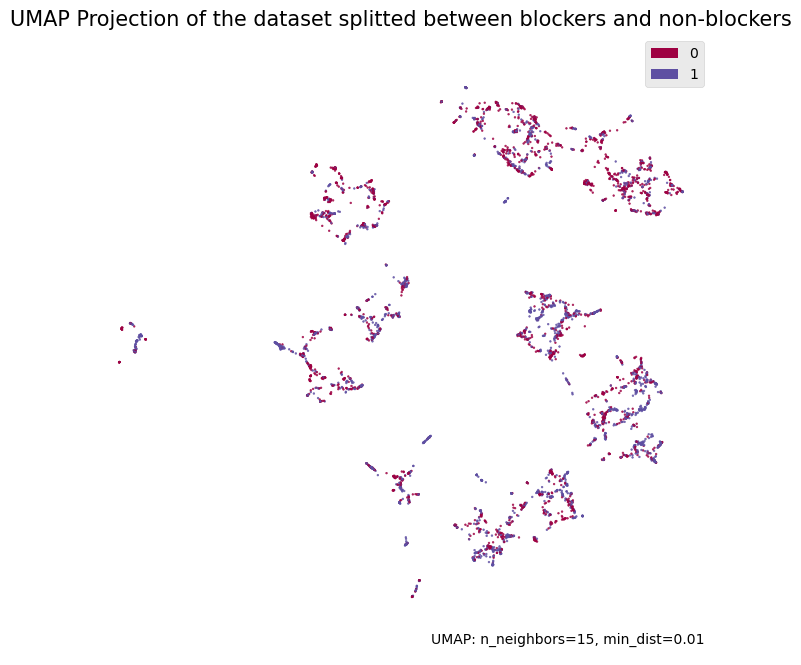

In [772]:
umap.plot.points(reducer, labels=df.Outcome, alpha=0.8)
plt.title('UMAP Projection of the dataset splitted between blockers and non-blockers', fontsize=15)
plt.gca().set_aspect('equal', 'datalim')

The structure obtained from UMAP is an intermediate topological representation and it can be simplified down to a weighted graph. Plotting the connectivity provides at least one basic diagnostic view that helps a user understand what is going on with an embedding. 

Text(0.5, 1.0, 'UMAP Connectivity Projection')

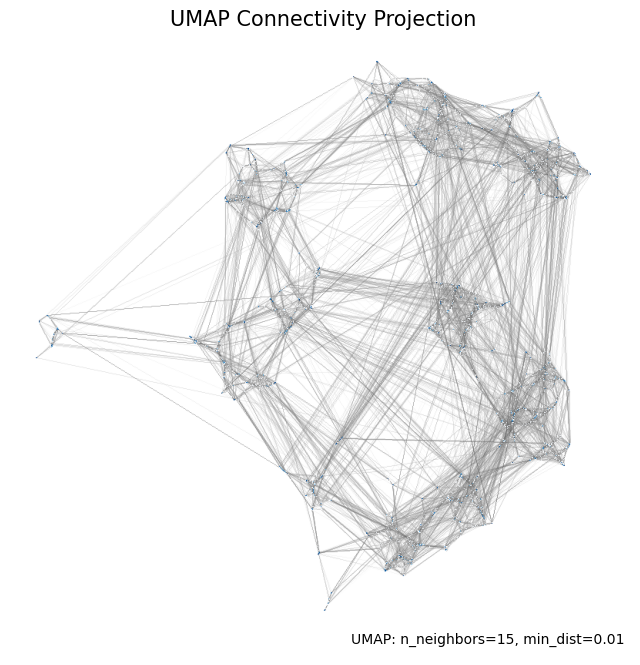

In [773]:

umap.plot.connectivity(reducer, show_points=True)
plt.title('UMAP Connectivity Projection', fontsize=15)

Furthermore, edge-bundling options provides a less busy view of connectivity, but can be expensive to compute. 

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Finally, using **HDBSCAN** (clustering algorithm), we are going to be able to form clusters. 

Text(0.5, 1.0, 'Graph showing the original dispersion of the dataset')

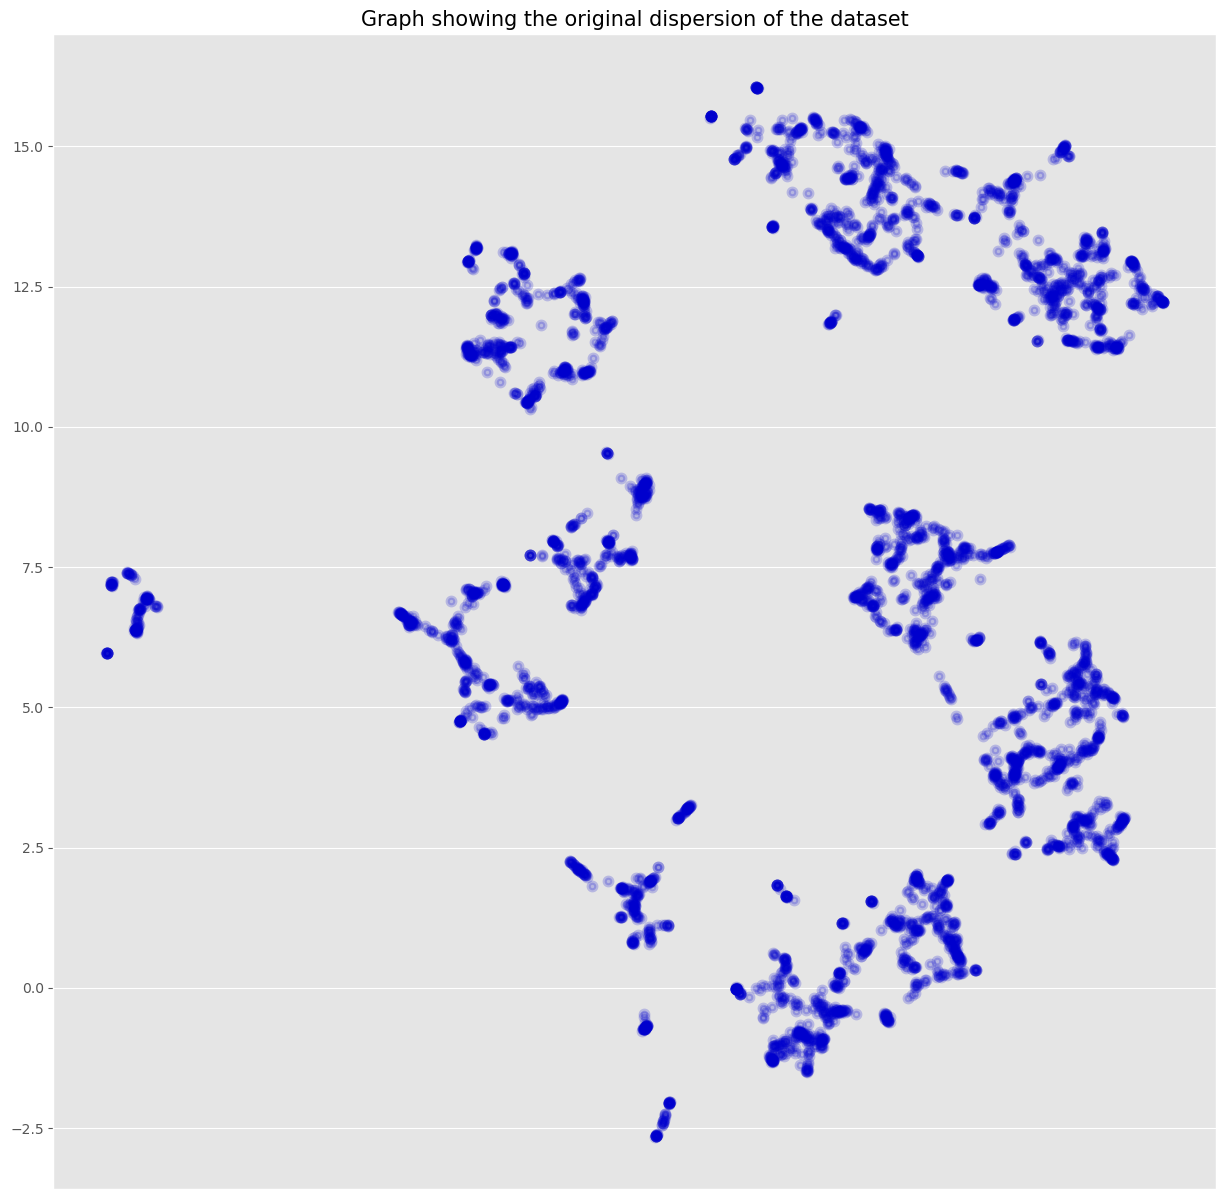

In [775]:
f, ax = plt.subplots(figsize=(15,15))
plt.scatter(embedding.T[0], embedding.T[1], c='mediumblue', **plot_kwds)      # to plot the clustering data set

frame = plt.gca()                                                             # to remove values on the y axe
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(True)

plt.title('Graph showing the original dispersion of the dataset', fontsize=15)

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

This technique is mostly based on single linkage clustering.

**1. Transform the space according to the density/sparsity.**

To find clusters we want to find the islands of higher density to distinguish them better from the noise. Indeed, a single noise data point can act as a bridge between islands, gluing them together. Therefore, we are aiming at making the core clustering more robust to noise. For that, we estimate the density by calculating the simplest distance to the k nearest neighbor also called 'core distance'. Further, a 'mutual reachability distance' between two centers of radius of defined core distance is found out. Finally, we can compare the mutual reachability distance to approximate the true density distribution. 

**2. Build the minimum spanning tree of the distance weighted graph.**

Now that we have a new mutual reachability metric on the data we want start finding the islands on dense data. We will consider the data as a weighted graph. The weight will be equal to the mutaul reachability distance of thoses points. Next, a descending threshold value will be applied in order to disconnect the graph into connected components.For that, the minimum spanning tree of the graph allows to build one edge at a time by adding the lowest weight edge. 

In [776]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=70, gen_min_span_tree=True)       # to cluster the data 
clusterer.fit(embedding)

HDBSCAN(gen_min_span_tree=True, min_cluster_size=70)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}


Text(0.5, 1.0, 'Histogram presenting the size of the clusters')

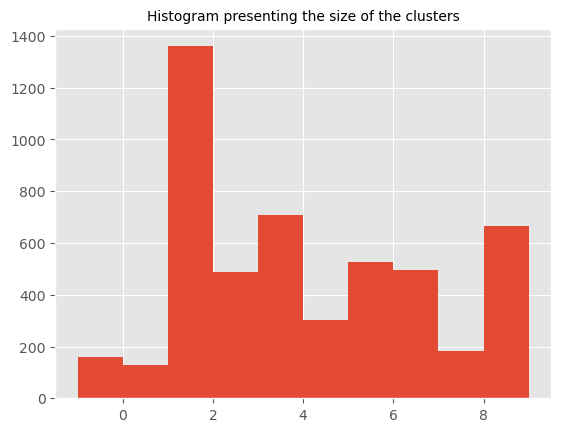

In [777]:
plt.hist(clusterer.labels_)
print(set(clusterer.labels_))
N = len(set(clusterer.labels_))

plt.title('Histogram presenting the size of the clusters', fontsize=10)

Text(0.5, 1.0, 'Minimum spanning tree for mutual reachability distance')

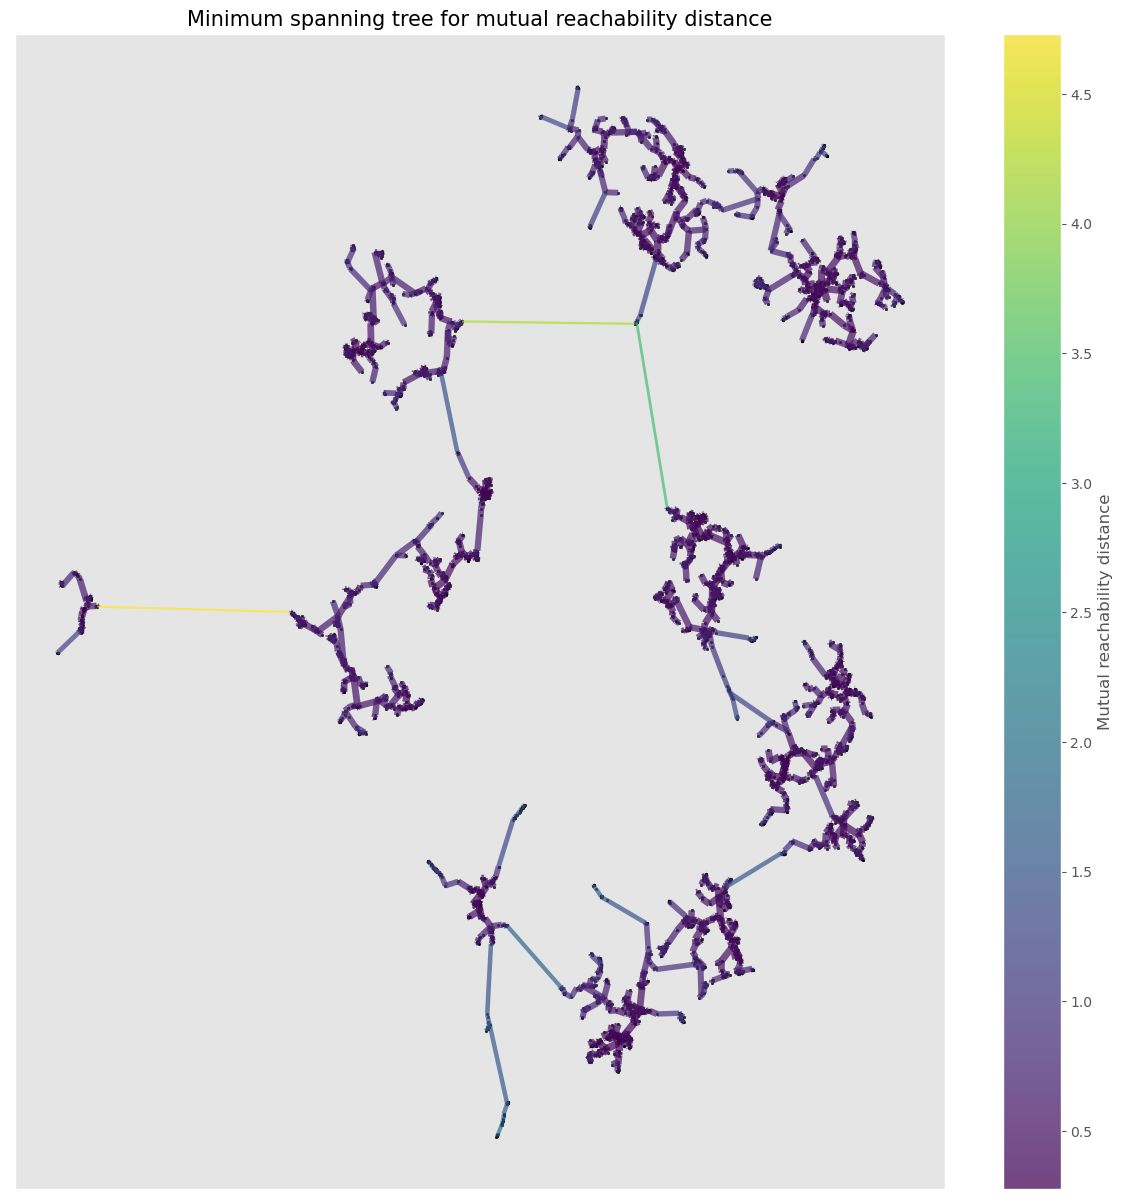

In [778]:
f, ax = plt.subplots(figsize=(15,15))
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.7,
                                      node_size=3,
                                      edge_linewidth=1.5)
plt.title('Minimum spanning tree for mutual reachability distance', fontsize=15)

**3. Construct a cluster hierarchy of connected components.**

Given the minimal spanning tree, the next step is to convert that into the hierarchy of connected components. The edges of the tree will be sorted in increasing order by distance. At each edge a merged cluster will be created after iterating. Via a union-find data structure, we will join two clusters at each edge. It stores a partition of a set into disjoint subsets. It provides operations for adding new sets, merging sets (replacing them by their union), and finding a representative member of a set. The last operation makes it possible to find out efficiently if any two elements are in the same or different sets.

The results can be viewed in the following dendrogram : 

Text(0.5, 1.0, 'Dendogram representing the cluster hierarchy of connected components')

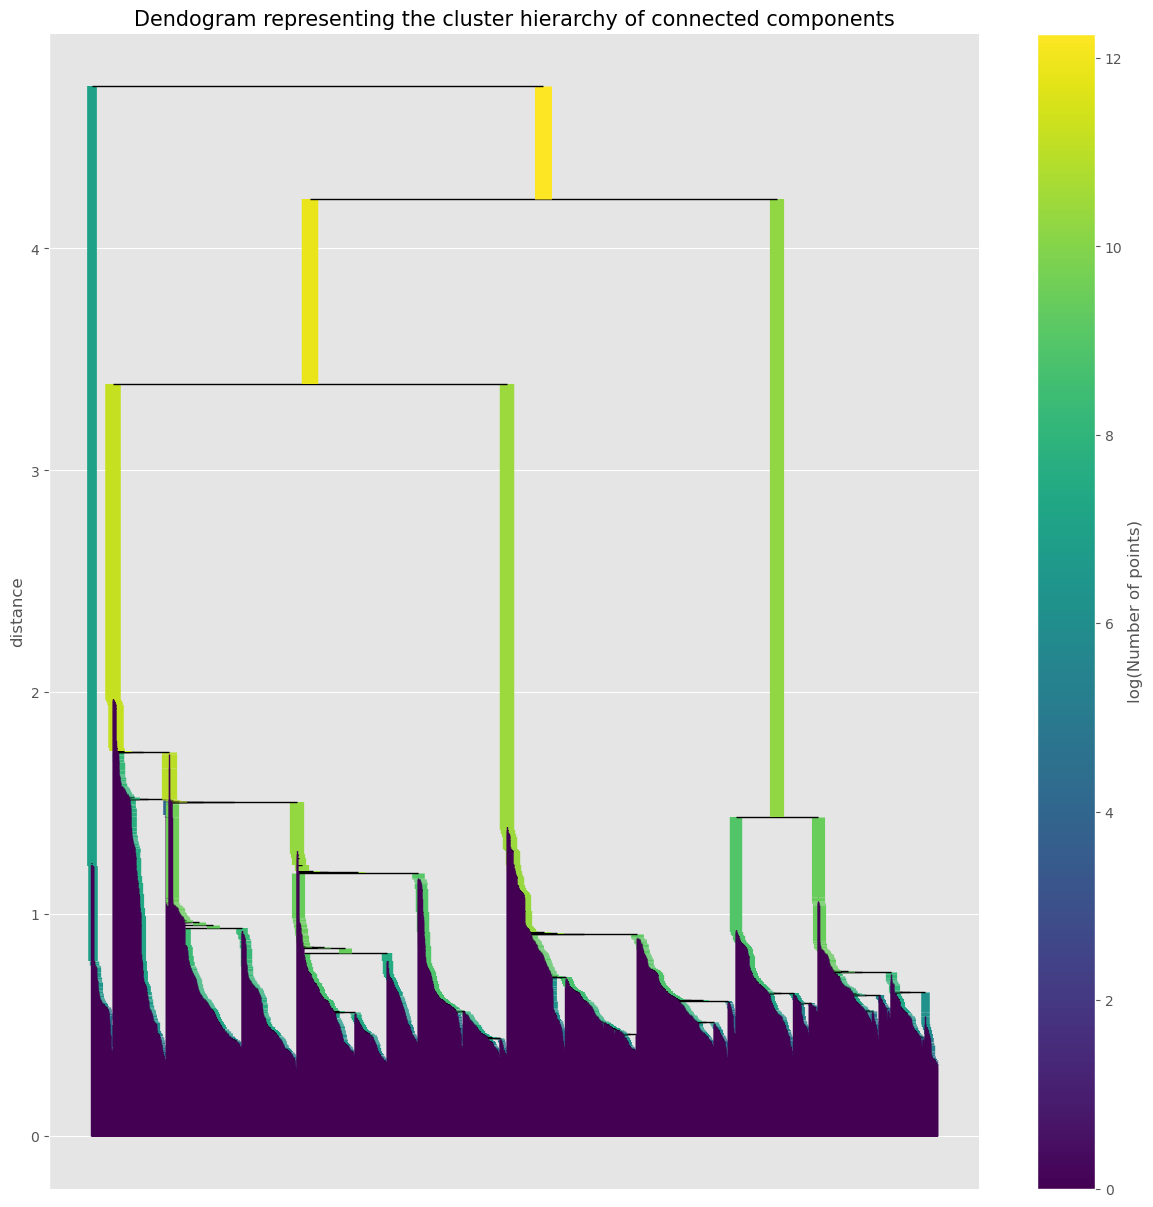

In [779]:
# Density Cluster Tree

plt.style.use('seaborn-pastel')
f, ax = plt.subplots(figsize=(15,15))
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
plt.title('Dendogram representing the cluster hierarchy of connected components', fontsize=15)    

As shown on the dendogram, any single linkage was eliminated. Given that hierarchy, the next step is to define set of flat clusters. This is most easily done with DBSCAN (declaring any singleton clusters at the cut level as noise). The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. 


**4. Condense the cluster hierarchy based on minimum cluster size.**

In order to extract the clusters, we need first to condense down the large and complicated cluster hierarchy into a smaller tree. 

As you can see in the hierarchy above it is often the case that a cluster split is one or two points splitting off from a cluster; and that is the key point – rather than seeing it as a cluster splitting into two new clusters we want to view it as a single persistent cluster that is ‘losing points’.

From the root, we walk through the hierarchy and see if each clusters is smaller as the minimum clustersize. If it the case, then this split is removed from the tree. 

Similar to the dendogram above, we can visualize the smaller tree : 

Text(0.5, 1.0, 'Dendogram representing the condensed cluster hierarchy')

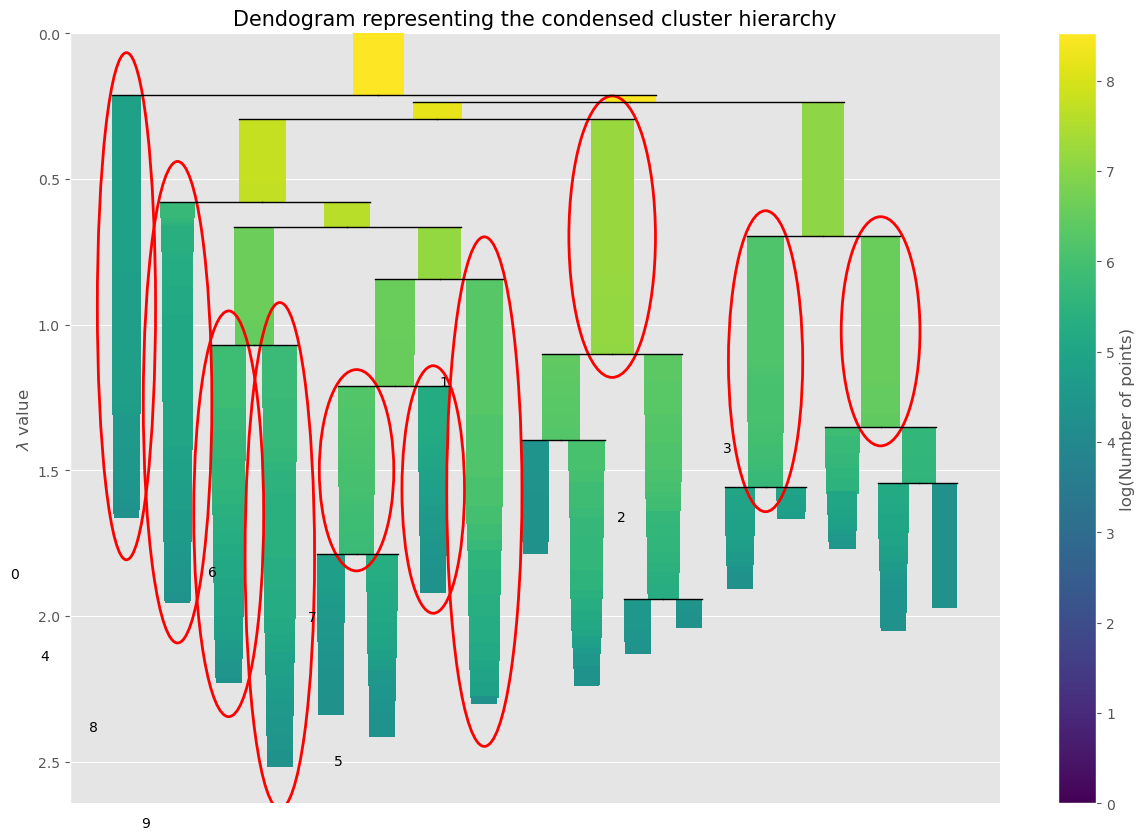

In [780]:
f, ax = plt.subplots(figsize=(15,10))
clusterer.condensed_tree_.plot(leaf_separation=1, cmap='viridis', select_clusters=True,
             label_clusters=True, selection_palette=None,
             axis=None, colorbar=True, log_size=True,
             max_rectangles_per_icicle=20)
plt.title('Dendogram representing the condensed cluster hierarchy', fontsize=15)


Text(0.5, 1.0, 'Dendogram representing the condensed cluster hierarchy')

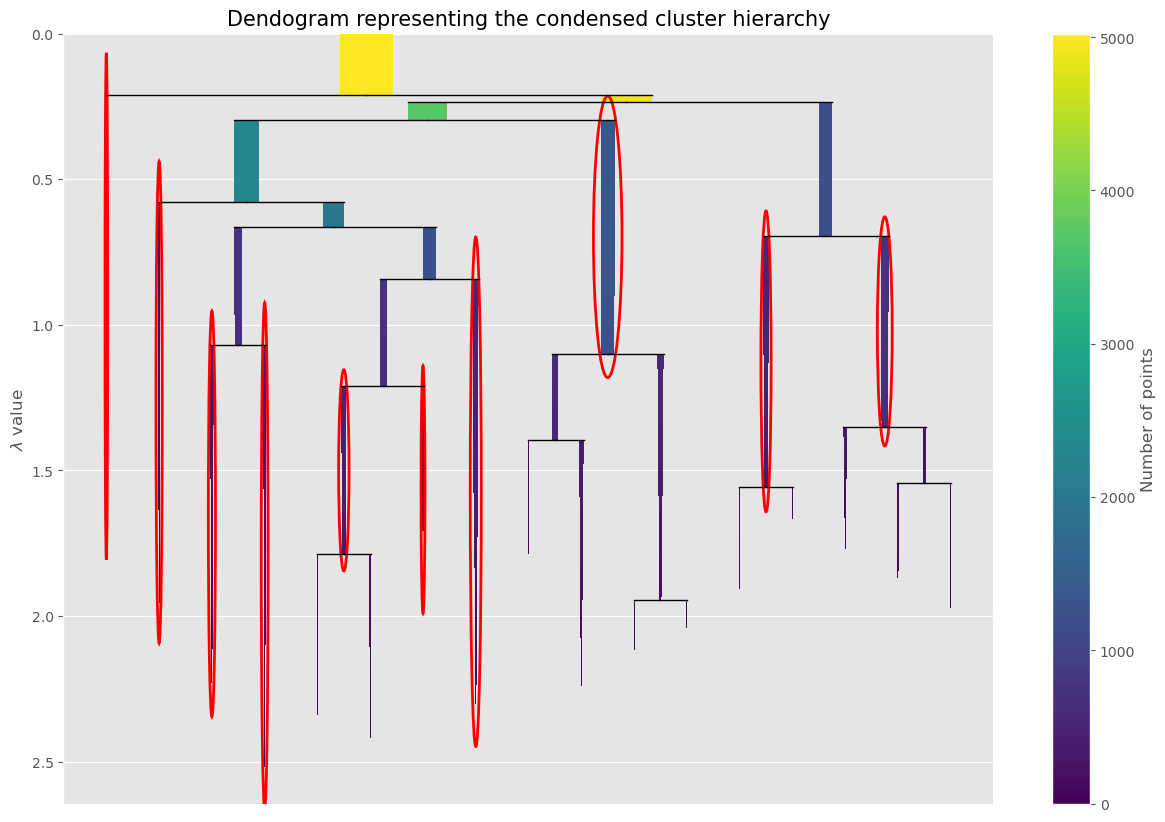

In [781]:
f, ax = plt.subplots(figsize=(15,10))
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.title('Dendogram representing the condensed cluster hierarchy', fontsize=15)

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**5. Extract the stable clusters from the condensed tree.**

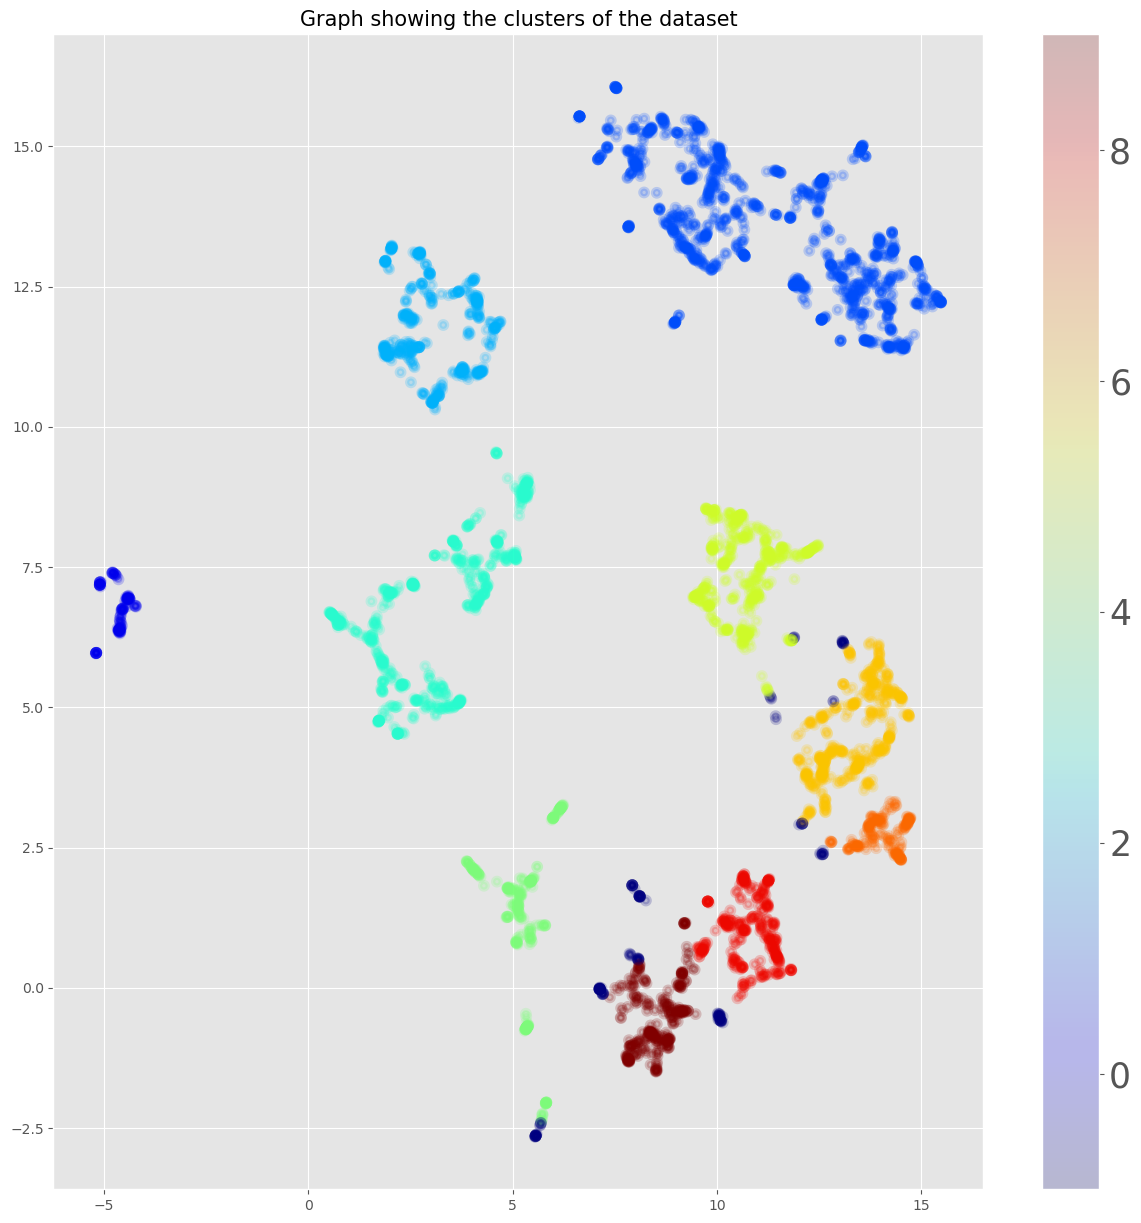

In [782]:
plot_kwds = {'alpha' : 0.2, 's' : 30, 'linewidths':3}   

# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

f, ax = plt.subplots(figsize=(15,15))
points = plt.scatter(embedding.T[0], embedding.T[1], c=clusterer.labels_, cmap=cmap, **plot_kwds)

frame = plt.gca()                                          # to remove values on the y axe
frame.axes.get_xaxis().set_visible(True)
frame.axes.get_yaxis().set_visible(True)

plt.title('Graph showing the clusters of the dataset', fontsize=15)
cbar = f.colorbar(points)
cbar.ax.tick_params(labelsize=25) 

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

To conclude, HDBSCAN has allowed to cluster the data.

In [783]:
clusterer.labels_  # an array of integer for each data sample ; samples from the same clusters get the same number assigned 

array([1, 1, 3, ..., 1, 5, 1])

In [784]:
clusterer.labels_.max()  # to determine the number of clusters by finding the largest cluster label

9

So we have a total of 11 clusters in the training dataset, with label 0 and -1 in addition. 

Importantly HDBSCAN is noise aware – it has a notion of data samples that are not assigned to any cluster. This is handled by assigning these samples the label -1. 

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------